# Modeling

### Import Relevant Libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, snowball
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.util import ngrams
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder 
from nltk.util import ngrams

nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix, classification_report, r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\capta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read in Processed Data

In [3]:
df = pd.read_parquet('./Data/processed_reports.parquet')

In [4]:
df.reset_index(inplace=True)

In [5]:
df.drop(['index'],axis=1,inplace=True)

### Create secondary classification target 

In [6]:
df['target'] = df.Round

In [7]:
df.target[df.target >= 6] = 0

In [8]:
df.target[df.target == 1] = 10

In [9]:
df.target[(df.target == 4) | (df.target == 5)] = 1

In [10]:
df.target[df.target == 3] = 2

In [11]:
df.target[df.target == 10] = 3

In [12]:
cleaned_df = df.drop(['report','processed_report','joined_report','weight_y','height_y'],axis=1) 

In [13]:
# Add _col to each column to prevent duplicate naming when combining with the scouting report words
cleaned_df = cleaned_df.add_suffix('_col')

In [14]:
cleaned_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,...,tackles_loss_career_col,sacks_career_col,pass_defended_career_col,fumbles_forced_season_col,fumbles_forced_career_col,college_conference_col,speed_col,shuttle_agility_col,cone_agility_col,pos_col
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,...,NaN,NaN,NaN,NaN,NaN,Mountain West Conference,88.187311,176.485482,136.815911,QB
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,...,NaN,NaN,NaN,NaN,NaN,None,120.996000,168.168738,130.199966,RB
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,...,NaN,NaN,NaN,NaN,NaN,None,107.614900,NaN,NaN,WR
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,...,NaN,NaN,NaN,NaN,NaN,None,97.457455,NaN,NaN,RB
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,RB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,Jeff Gunter,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,252,...,38.5,17.0,4.0,2.0,9.0,Sun Belt Conference,105.744617,144.109521,137.671457,LB
4205,Trenton Gill,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,255,...,NaN,NaN,NaN,NaN,NaN,Atlantic Coast Conference,NaN,NaN,NaN,P
4206,Jesse Luketa,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,256,...,11.5,0.5,6.0,NaN,NaN,Big Ten Conference,88.494256,NaN,NaN,LB
4207,Marquis Hayes,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,257,...,NaN,NaN,NaN,NaN,NaN,Big Twelve Conference,80.603451,NaN,NaN,OL


### Add grades and rankings for 2022 draft

In [15]:
grades22 = pd.read_excel('./Data/addgrades.xlsx')

In [16]:
cleaned_df.pos_rk_col[cleaned_df.year_col == 2022] = grades22.pos_rk_col
cleaned_df.ovr_rk_col[cleaned_df.year_col == 2022] = grades22.ovr_rk_col
cleaned_df.grade_col[cleaned_df.year_col == 2022] = grades22.grade_col

C:\Users\capta\AppData\Local\Temp\ipykernel_13660\2333570552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.pos_rk_col[cleaned_df.year_col == 2022] = grades22.pos_rk_col
C:\Users\capta\AppData\Local\Temp\ipykernel_13660\2333570552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.ovr_rk_col[cleaned_df.year_col == 2022] = grades22.ovr_rk_col
C:\Users\capta\AppData\Local\Temp\ipykernel_13660\2333570552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [17]:
cleaned_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,...,tackles_loss_career_col,sacks_career_col,pass_defended_career_col,fumbles_forced_season_col,fumbles_forced_career_col,college_conference_col,speed_col,shuttle_agility_col,cone_agility_col,pos_col
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,...,NaN,NaN,NaN,NaN,NaN,Mountain West Conference,88.187311,176.485482,136.815911,QB
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,...,NaN,NaN,NaN,NaN,NaN,None,120.996000,168.168738,130.199966,RB
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,...,NaN,NaN,NaN,NaN,NaN,None,107.614900,NaN,NaN,WR
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,...,NaN,NaN,NaN,NaN,NaN,None,97.457455,NaN,NaN,RB
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,RB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,Jeff Gunter,2022.0,NaN,NaN,18.0,198.0,55.0,23.0,7,252,...,38.5,17.0,4.0,2.0,9.0,Sun Belt Conference,105.744617,144.109521,137.671457,LB
4205,Trenton Gill,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,255,...,NaN,NaN,NaN,NaN,NaN,Atlantic Coast Conference,NaN,NaN,NaN,P
4206,Jesse Luketa,2022.0,NaN,NaN,11.0,167.0,59.0,23.0,7,256,...,11.5,0.5,6.0,NaN,NaN,Big Ten Conference,88.494256,NaN,NaN,LB
4207,Marquis Hayes,2022.0,NaN,NaN,10.0,139.0,64.0,23.0,7,257,...,NaN,NaN,NaN,NaN,NaN,Big Twelve Conference,80.603451,NaN,NaN,OL


### TFIDF Vectorizing

In [18]:
tf = TfidfVectorizer(ngram_range=(1,3),min_df=.062,max_df =.75)

In [19]:
X = tf.fit_transform(df.joined_report)

In [20]:
report_df = pd.DataFrame(X.toarray(),columns=tf.get_feature_names())

In [21]:
report_df.columns

Index(['2002', '2003', '2004', '2005', '2006', '2016', 'abil', 'adequ', 'also',
       'appear',
       ...
       'two season', 'upsid', 'valu', 'versatil', 'well', 'work', 'yard',
       'year', 'year starter', 'zone'],
      dtype='object', length=198)

### Merge TFIDF features with all other features

In [22]:
model_df = pd.concat([cleaned_df,report_df],axis=1)

In [23]:
model_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,...,two season,upsid,valu,versatil,well,work,yard,year,year starter,zone
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.302746,0.197995,0.0,0.000000
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,...,0.0,0.0,0.0,0.128312,0.0,0.130273,0.338669,0.000000,0.0,0.000000
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.261304,0.113928,0.0,0.000000
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.200609,0.000000,0.0,0.000000
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.282241,0.061528,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,Jeff Gunter,2022.0,NaN,NaN,18.0,198.0,55.0,23.0,7,252,...,0.0,0.0,0.0,0.199357,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4205,Trenton Gill,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,255,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.370394,0.000000,0.0,0.000000
4206,Jesse Luketa,2022.0,NaN,NaN,11.0,167.0,59.0,23.0,7,256,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4207,Marquis Hayes,2022.0,NaN,NaN,10.0,139.0,64.0,23.0,7,257,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.237427


### Count Vectorizer

In [24]:
# Alternative Data that uses CountVectorizer instead of TFIDF
cvec = CountVectorizer(ngram_range=(1,3),min_df=.062,max_df=.75)
X_cvec = cvec.fit_transform(df.joined_report)
cvec_df = pd.DataFrame(X_cvec.toarray(),columns=cvec.get_feature_names())
cvec_model_df = pd.concat([cleaned_df,cvec_df],axis=1)

### Modeling Functions

In [25]:
def get_model_results (model):

    # Fit GridSearch for model
    model.fit(X_train,y_train)

    # Get y_preds
    y_pred = model.predict(X_test)

    # Set metric scores with print labels
    r2 = f"r2 = {round(r2_score(y_test,y_pred),4)}"
    MSE = f"MSE = {round(mean_squared_error(y_test,y_pred),2)}"
    
    return r2, MSE

In [26]:
def graph_model_results(model):
    
    y_pred = model.predict(X_test)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.regplot(x=y_pred,y=y_test,line_kws={"color": "red"})
    plt.xlabel('Predicted Pick')
    plt.ylabel('Pick')
    plt.title('Actual Pick vs. Model Predicted Pick')
    plt.xlim(-5,265)
    plt.ylim(-5,265)
    plt.annotate(f'r2 = {round(r2_score(y_test,y_pred),3)}',xy=(230,240));
    return

### Linear Regression

In [26]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('lin',LinearRegression())
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
}

# GridSearch with Cross Validation of 5
lin = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [27]:
# Set start time
start_time = time.time()

# Call results function
print(get_model_results(lin))

# Return run time
print(round((time.time() - start_time)/60,1),'minutes')

('r2 = 0.5361', 'MSE = 2302.8')
0.0 minutes


C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

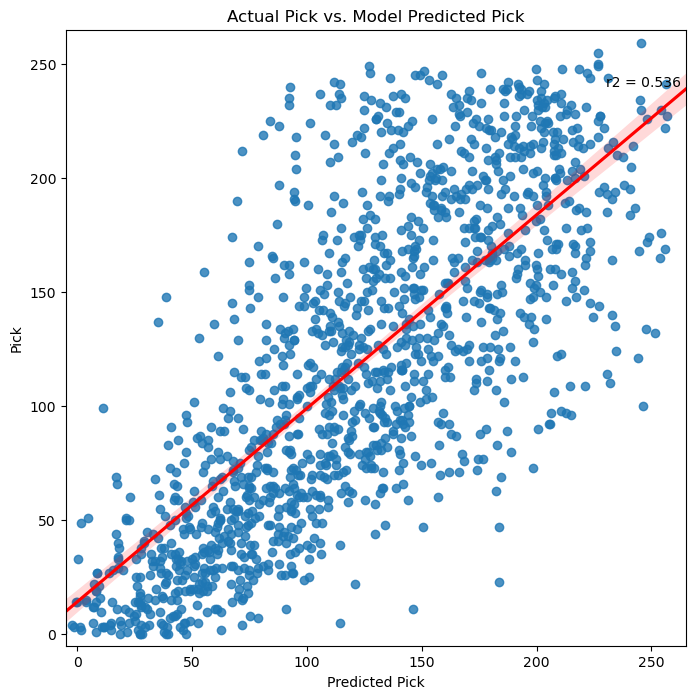

In [28]:
# Graph model results
graph_model_results(lin)

### Random Forest

In [29]:
# Set X and y
X = cvec_model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(cvec_model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
rfc_pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('forest',RandomForestRegressor())
])

# Fit model
rfc_pipe.fit(X_train, y_train)

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'forest__n_estimators':[102],
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'forest__max_depth':[24],
    'forest__min_samples_split':[2],
    'forest__min_samples_leaf':[6]
}

# GridSearch with Cross Validation of 5
cvec_forest = GridSearchCV(estimator=rfc_pipe,
                          param_grid=grid,
                          cv=5)

In [30]:
# Set start time
start_time = time.time()

# Call results function
print(get_model_results(cvec_forest))

# Return run time
print(round((time.time() - start_time)/60,1),'minutes')

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

('r2 = 0.6788', 'MSE = 1594.56')
0.9 minutes


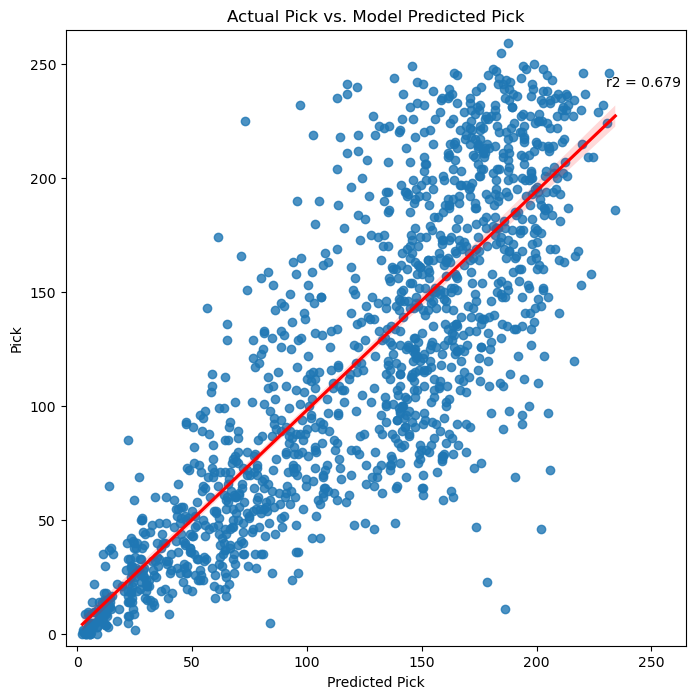

In [31]:
# Graph model results
graph_model_results(cvec_forest)

In [32]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
rfc_pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('forest',RandomForestRegressor())
])

# Fit model
rfc_pipe.fit(X_train, y_train)

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'forest__n_estimators':[102],
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'forest__max_depth':[24],
    'forest__min_samples_split':[2],
    'forest__min_samples_leaf':[6]
}

# GridSearch with Cross Validation of 5
forest = GridSearchCV(estimator=rfc_pipe,
                          param_grid=grid,
                          cv=5)

In [33]:
# Set start time
start_time = time.time()

# Call results function
print(get_model_results(forest))

# Return run time
print(round((time.time() - start_time)/60,1),'minutes')

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

('r2 = 0.6758', 'MSE = 1609.27')
1.2 minutes


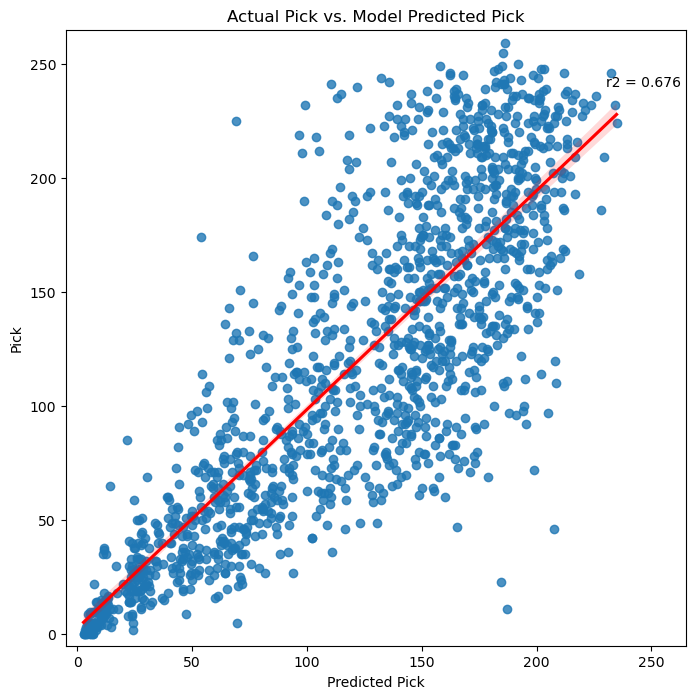

In [34]:
# Graph model results
graph_model_results(forest)

### Get Weights from Random Forest Model

In [35]:
# Get names of the OneHotEncoded Columns
rfc_pipe[0].transformers_[1][1].named_steps['ohe'].get_feature_names()

array(['x0_Atlantic Coast Conference', 'x0_Big East',
       'x0_Big Sky Conference', 'x0_Big South Conference',
       'x0_Big Ten Conference', 'x0_Big Twelve Conference',
       'x0_Central Intercollegiate Athletic Association',
       'x0_Colonial Athletic Association', 'x0_Conference USA',
       'x0_Great Lakes Intercollegiate Athletic Conference',
       'x0_Great Northwest Athletic Conference',
       'x0_Great West Football Conference', 'x0_Gulf South Conference',
       'x0_Independent', 'x0_Ivy League', 'x0_Lone Star Conference',
       'x0_Mid-America Intercollegiate Athletic Association',
       'x0_Mid-American Conference', 'x0_Mid-Eastern Athletic Conference',
       'x0_Minnesota Intercollegiate Athletic Conference',
       'x0_Missouri Valley Football Conference',
       'x0_Mountain West Conference', 'x0_Northeast Conference',
       'x0_Northern Sun Intercollegiate Conference',
       'x0_Ohio Athletic Conference', 'x0_Ohio Valley Conference',
       'x0_Pacific Twelv

In [36]:
# Get all the other X_train columns
X_train.columns.to_list()

['weight_x_col',
 'height_x_col',
 'pos_rk_col',
 'ovr_rk_col',
 'grade_col',
 'age_col',
 'reportlen_col',
 'forty_yd_col',
 'vertical_col',
 'bench_reps_col',
 'broad_jump_col',
 'cone_col',
 'shuttle_col',
 'g_season_col',
 'def_int_season_col',
 'def_int_yds_season_col',
 'def_int_yds_per_int_season_col',
 'def_int_career_col',
 'def_int_yds_career_col',
 'def_int_yds_per_int_career_col',
 'pass_cmp_season_col',
 'pass_att_season_col',
 'pass_cmp_pct_season_col',
 'pass_yds_season_col',
 'pass_yds_per_att_season_col',
 'adj_pass_yds_per_att_season_col',
 'pass_td_season_col',
 'pass_int_season_col',
 'pass_rating_season_col',
 'pass_cmp_career_col',
 'pass_att_career_col',
 'pass_cmp_pct_career_col',
 'pass_yds_career_col',
 'pass_yds_per_att_career_col',
 'adj_pass_yds_per_att_career_col',
 'pass_td_career_col',
 'pass_int_career_col',
 'pass_rating_career_col',
 'rush_att_season_col',
 'rush_yds_season_col',
 'rush_yds_per_att_season_col',
 'rush_td_season_col',
 'rec_season_col'

In [44]:
# Combine the X_train columns and the OneHotEncoded problems in the proper order
# EXTREMELY important as otherwise the feature names will be mismatched
feature_cols = ['weight_x_col',
 'height_x_col',
 'pos_rk_col',
 'ovr_rk_col',
 'grade_col',
 'age_col',
 'reportlen_col',
 'forty_yd_col',
 'vertical_col',
 'bench_reps_col',
 'broad_jump_col',
 'cone_col',
 'shuttle_col',
 'g_season_col',
 'def_int_season_col',
 'def_int_yds_season_col',
 'def_int_yds_per_int_season_col',
 'def_int_career_col',
 'def_int_yds_career_col',
 'def_int_yds_per_int_career_col',
 'pass_cmp_season_col',
 'pass_att_season_col',
 'pass_cmp_pct_season_col',
 'pass_yds_season_col',
 'pass_yds_per_att_season_col',
 'adj_pass_yds_per_att_season_col',
 'pass_td_season_col',
 'pass_int_season_col',
 'pass_rating_season_col',
 'pass_cmp_career_col',
 'pass_att_career_col',
 'pass_cmp_pct_career_col',
 'pass_yds_career_col',
 'pass_yds_per_att_career_col',
 'adj_pass_yds_per_att_career_col',
 'pass_td_career_col',
 'pass_int_career_col',
 'pass_rating_career_col',
 'rush_att_season_col',
 'rush_yds_season_col',
 'rush_yds_per_att_season_col',
 'rush_td_season_col',
 'rec_season_col',
 'rec_yds_season_col',
 'rec_yds_per_rec_season_col',
 'scrim_att_season_col',
 'scrim_yds_season_col',
 'scrim_yds_per_att_season_col',
 'scrim_td_season_col',
 'rush_att_career_col',
 'rush_yds_career_col',
 'rush_yds_per_att_career_col',
 'rush_td_career_col',
 'rec_career_col',
 'rec_yds_career_col',
 'rec_yds_per_rec_career_col',
 'rec_td_career_col',
 'scrim_att_career_col',
 'scrim_yds_career_col',
 'scrim_yds_per_att_career_col',
 'scrim_td_career_col',
 'fumbles_rec_yds_career_col',
 'fumbles_rec_td_career_col',
 'rec_td_season_col',
 'def_int_td_season_col',
 'def_int_td_career_col',
 'fumbles_rec_career_col',
 'fumbles_rec_yds_season_col',
 'fumbles_rec_td_season_col',
 'fumbles_rec_season_col',
 'tackles_solo_season_col',
 'tackles_assists_season_col',
 'tackles_total_season_col',
 'tackles_loss_season_col',
 'sacks_season_col',
 'pass_defended_season_col',
 'tackles_solo_career_col',
 'tackles_assists_career_col',
 'tackles_total_career_col',
 'tackles_loss_career_col',
 'sacks_career_col',
 'pass_defended_career_col',
 'fumbles_forced_season_col',
 'fumbles_forced_career_col',
 'x0_Atlantic Coast Conference', 'x0_Big East',
       'x0_Big Sky Conference', 'x0_Big South Conference',
       'x0_Big Ten Conference', 'x0_Big Twelve Conference',
       'x0_Central Intercollegiate Athletic Association',
       'x0_Colonial Athletic Association', 'x0_Conference USA',
       'x0_Great Lakes Intercollegiate Athletic Conference',
       'x0_Great Northwest Athletic Conference',
       'x0_Great West Football Conference', 'x0_Gulf South Conference',
       'x0_Independent', 'x0_Ivy League', 'x0_Lone Star Conference',
       'x0_Mid-America Intercollegiate Athletic Association',
       'x0_Mid-American Conference', 'x0_Mid-Eastern Athletic Conference',
       'x0_Minnesota Intercollegiate Athletic Conference',
       'x0_Missouri Valley Football Conference',
       'x0_Mountain West Conference', 'x0_Northeast Conference',
       'x0_Northern Sun Intercollegiate Conference',
       'x0_Ohio Athletic Conference', 'x0_Ohio Valley Conference',
       'x0_Pacific Twelve Conference', 'x0_Patriot League',
       'x0_Pennsylvania State Athletic Conference',
       'x0_Pioneer Football League', 'x0_South Atlantic Conference',
       'x0_Southeastern Conference', 'x0_Southern Conference',
       'x0_Southern Intercollegiate Athletic Conference',
       'x0_Southland Conference', 'x0_Southwestern Athletic Conference',
       'x0_Sun Belt Conference', 'x0_Western Athletic Conference',
       'x0_Wisconsin Intercollegiate Athletic Conference','x0_None','speed_col',
 'shuttle_agility_col',
 'cone_agility_col','x1_DB', 'x1_DE', 'x1_DL', 'x1_DT', 'x1_FB', 'x1_K', 'x1_LB',
       'x1_LS', 'x1_OL', 'x1_P', 'x1_QB', 'x1_RB', 'x1_S', 'x1_TE',
       'x1_WR','2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2016',
 'abil',
 'adequ',
 'also',
 'appear',
 'arm',
 'athlet',
 'athlet abil',
 'athletic',
 'averag',
 'back',
 'backup',
 'ball',
 'ball skill',
 'best',
 'better',
 'big',
 'block',
 'blocker',
 'bodi',
 'burst',
 'career',
 'catch',
 'class',
 'close',
 'colleg',
 'combin',
 'come',
 'concern',
 'consist',
 'contribut',
 'corner',
 'could',
 'coverag',
 'day',
 'defend',
 'defens',
 'develop',
 'draft',
 'durabl',
 'earli',
 'edg',
 'effect',
 'eight',
 'elit',
 'end',
 'end speed',
 'enough',
 'excel',
 'experi',
 'explos',
 'field',
 'final',
 'finish',
 'first',
 'fit',
 'five',
 'flash',
 'flash abil',
 'footbal',
 'forc',
 'four',
 'frame',
 'freshman',
 'fumbl',
 'game',
 'get',
 'good',
 'grade',
 'great',
 'guard',
 'hand',
 'high',
 'howev',
 'ideal',
 'improv',
 'inconsist',
 'injuri',
 'insid',
 'instinct',
 'intercept',
 'job',
 'junior',
 'lack',
 'lack ideal',
 'last',
 'late',
 'left',
 'length',
 'level',
 'like',
 'limit',
 'line',
 'lineback',
 'long',
 'loss',
 'lot',
 'make',
 'man',
 'miss',
 'move',
 'much',
 'natur',
 'need',
 'nfl',
 'offens',
 'one',
 'outsid',
 'outstand',
 'overal',
 'pass',
 'pass rusher',
 'physic',
 'pick',
 'play',
 'play game',
 'player',
 'point',
 'posit',
 'possess',
 'potenti',
 'power',
 'pro',
 'product',
 'project',
 'prospect',
 'quarterback',
 'quick',
 'rang',
 'receiv',
 'record',
 'redshirt',
 'return',
 'right',
 'round',
 'round pick',
 'rout',
 'rout runner',
 'run',
 'run defend',
 'runner',
 'rush',
 'rusher',
 'sack',
 'safeti',
 'scheme',
 'season',
 'second',
 'senior',
 'set',
 'short',
 'show',
 'six',
 'size',
 'skill',
 'special',
 'special team',
 'speed',
 'start',
 'start game',
 'starter',
 'still',
 'strength',
 'strong',
 'tackl',
 'tackl loss',
 'take',
 'team',
 'techniqu',
 'term',
 'three',
 'three season',
 'tight',
 'time',
 'top',
 'top end',
 'top end speed',
 'total',
 'touchdown',
 'tough',
 'true',
 'true freshman',
 'two',
 'two season',
 'upsid',
 'valu',
 'versatil',
 'well',
 'work',
 'yard',
 'year',
 'year starter',
 'zone']

In [38]:
# Get the weight values of the Random Forest Model
weights = rfc_pipe[-1].feature_importances_

In [39]:
# Zip the names and the weights together into a DataFrame
coefs = pd.DataFrame(zip(feature_cols,weights))

### Sorted Results of the Weights of the Random Forest Model

In [40]:
coefs.sort_values(by=1,ascending=False).head(20)

,0,1
3,ovr_rk_col,0.572544
4,grade_col,0.128730
2,pos_rk_col,0.009255
6,reportlen_col,0.008060
84,x0_Atlantic Coast Conference,0.005467
7,forty_yd_col,0.005161
1,height_x_col,0.004363
0,weight_x_col,0.004335
85,x0_Big East,0.003871
206,footbal,0.003498


### KNN

In [41]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('knn',KNeighborsRegressor())
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'knn__n_neighbors':[30,40]
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#     'forest__max_depth':[4,12,None],
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

# GridSearch with Cross Validation of 5
knn = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [42]:
# Set start time
start_time = time.time()

# Call results function
print(get_model_results(knn))

# Return run time
print(round((time.time() - start_time)/60,1),'minutes')

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\

('r2 = 0.2221', 'MSE = 3861.55')
0.0 minutes


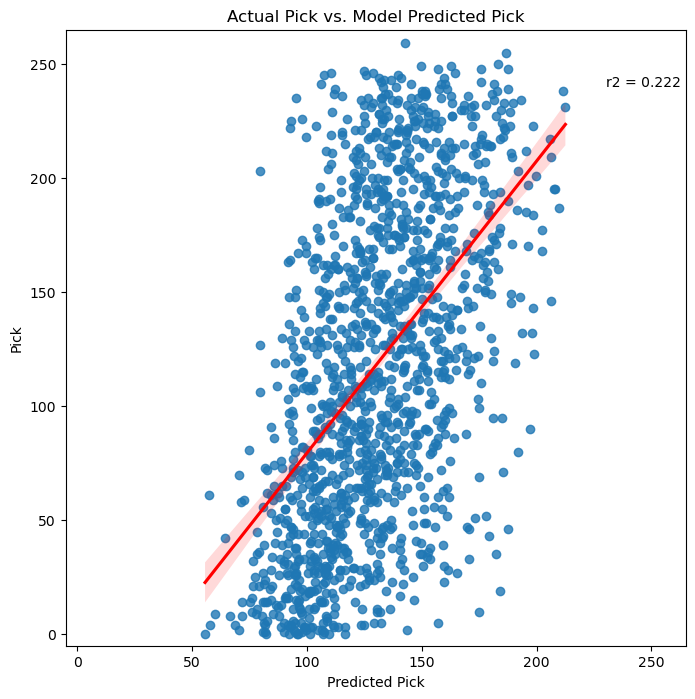

In [43]:
# Graph model results
graph_model_results(knn)

### Decision Tree

In [44]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('tree',DecisionTreeRegressor(random_state=42))
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)]
#     'tree__n_estimators':[75,100,125],
#     'tree__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#     'tree__max_depth':[4,12,None],
#     'tree__min_samples_split':[1,2,3],
#     'tree__min_samples_leaf':[1,2,3]
}

# GridSearch with Cross Validation of 5
tree = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [45]:
# Set start time
start_time = time.time()

# Call results function
print(get_model_results(tree))

# Return run time
print(round((time.time() - start_time)/60,1),'minutes')

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

('r2 = 0.3307', 'MSE = 3322.36')
0.0 minutes


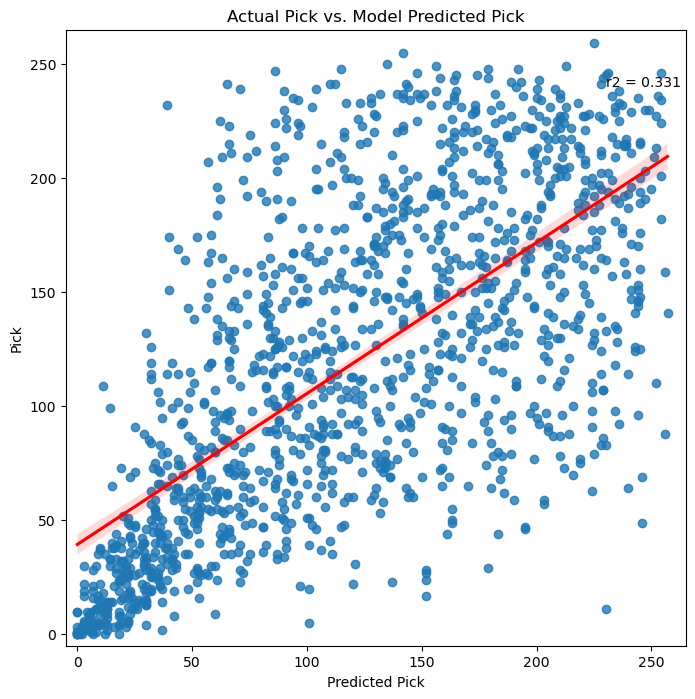

In [46]:
# Graph model results
graph_model_results(tree)

### XGBoost

In [47]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('xgb',XGBRegressor())
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'xgb__max_depth':[2,1],
    'xgb__eta':[.2,.22],
    'xgb__gamma':[0,.15]
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

# GridSearch with Cross Validation of 5
xgb = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [48]:
# Set start time
start_time = time.time()

# Call results function
print(get_model_results(xgb))

# Return run time
print(round((time.time() - start_time)/60,1),'minutes')

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta

('r2 = 0.671', 'MSE = 1633.26')
0.4 minutes


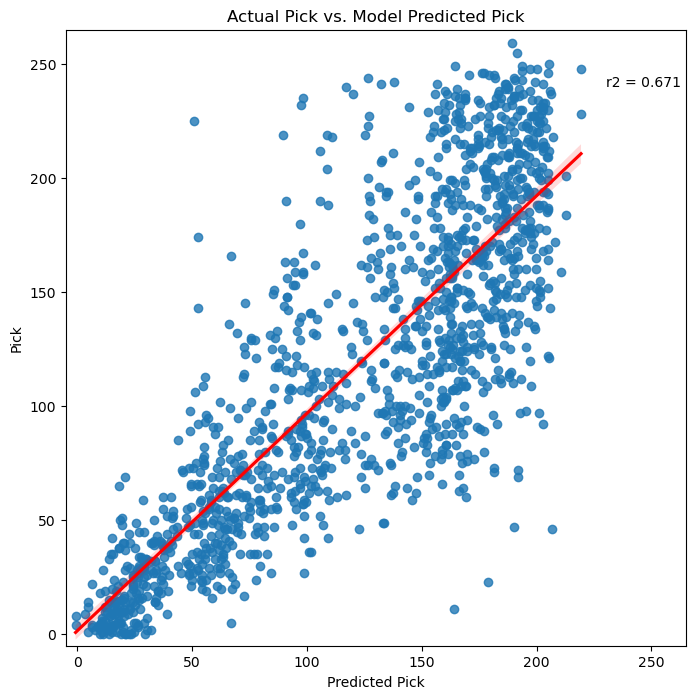

In [49]:
# Graph model results
graph_model_results(xgb)

### ADABoost

In [50]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('ada',AdaBoostRegressor(random_state=42))
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'ada__n_estimators':[42,40],
    'ada__learning_rate':[.35],
    'ada__loss':['linear','square','exponential']
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

# GridSearch with Cross Validation of 5
ada = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [51]:
# Set start time
start_time = time.time()

# Call results function
print(get_model_results(ada))

# Return run time
print(round((time.time() - start_time)/60,1),'minutes')

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta

('r2 = 0.6586', 'MSE = 1694.65')
1.2 minutes


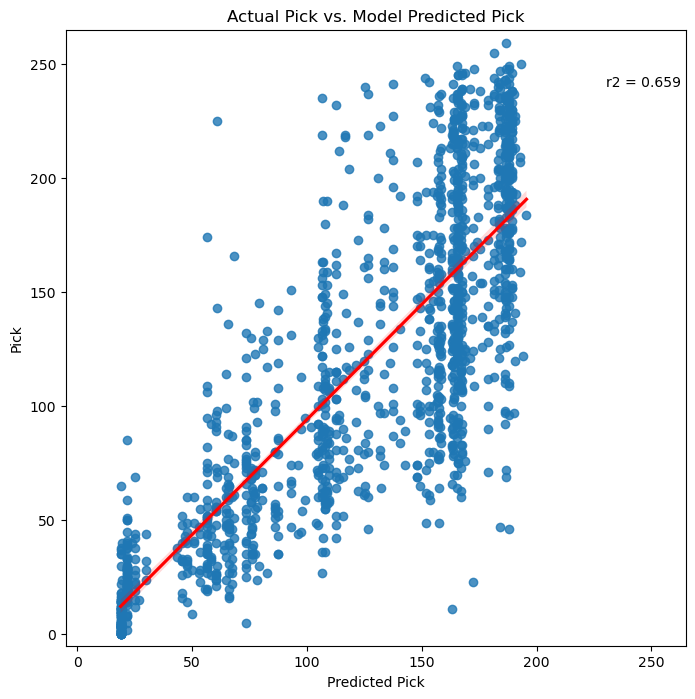

In [52]:
# Graph model results
graph_model_results(ada)

### GradientBoost

In [53]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('grad',GradientBoostingRegressor(random_state=42))
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'grad__n_estimators':[92],
    'grad__learning_rate':[.05],
#     'grad__loss':['absolute_error','squared_error','huber','quantile'],
    'grad__min_samples_split':[2],
    'grad__min_samples_leaf':[2],
    'grad__max_depth':[4],
    'grad__min_impurity_decrease':[.3]
}

# GridSearch with Cross Validation of 5
grad = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [54]:
# Set start time
start_time = time.time()

# Call results function
print(get_model_results(grad))

# Return run time
print(round((time.time() - start_time)/60,1),'minutes')

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

('r2 = 0.681', 'MSE = 1583.63')
0.6 minutes


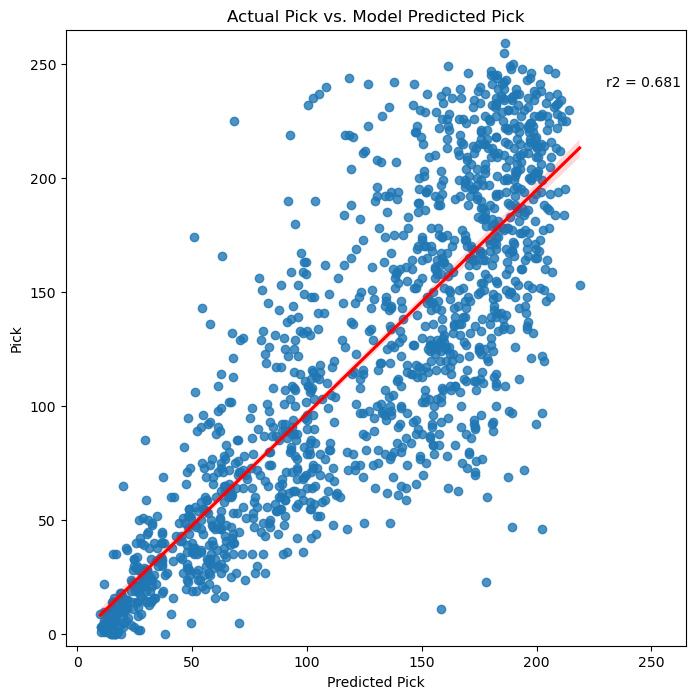

In [55]:
# Graph model results
graph_model_results(grad)

In [38]:
# Set X and y
X = cvec_model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(cvec_model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
grad_pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('grad',GradientBoostingRegressor(random_state=42))
])

# Fit model
grad_pipe.fit(X_train, y_train)

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'grad__n_estimators':[92],
    'grad__learning_rate':[.05],
#     'grad__loss':['absolute_error','squared_error','huber','quantile'],
    'grad__min_samples_split':[2],
    'grad__min_samples_leaf':[2],
    'grad__max_depth':[4],
    'grad__min_impurity_decrease':[.3]
}

# GridSearch with Cross Validation of 5
cvec_grad = GridSearchCV(estimator=cvec_grad_pipe,
                          param_grid=grid,
                          cv=5)

In [39]:
# Set start time
start_time = time.time()

# Call results function
print(get_model_results(cvec_grad))

# Return run time
print(round((time.time() - start_time)/60,1),'minutes')

# Set y_pred
y_pred = cvec_grad.predict(X_test)

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

('r2 = 0.6823', 'MSE = 1577.25')
0.5 minutes


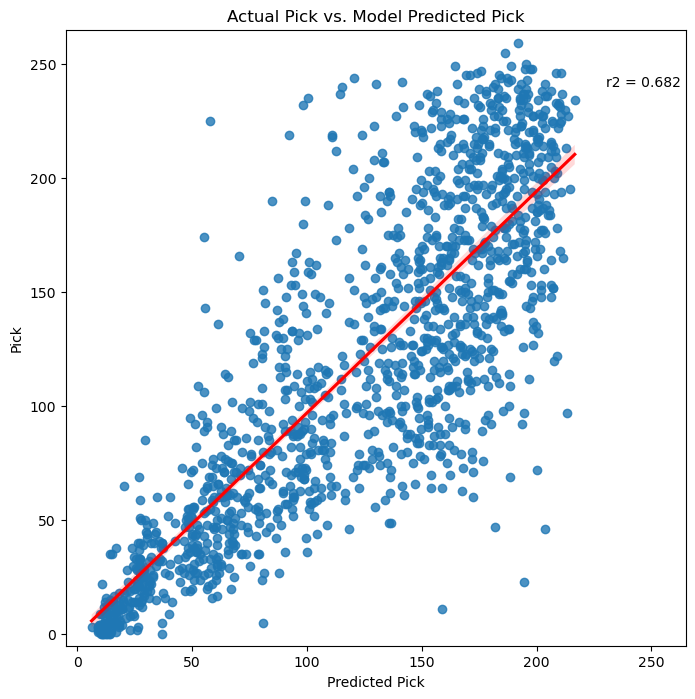

In [40]:
# Graph model results
graph_model_results(cvec_grad)

In [41]:
# Get names of the OneHotEncoded Columns
grad_pipe[0].transformers_[1][1].named_steps['ohe'].get_feature_names()

array(['x0_Atlantic Coast Conference', 'x0_Big East',
       'x0_Big Sky Conference', 'x0_Big South Conference',
       'x0_Big Ten Conference', 'x0_Big Twelve Conference',
       'x0_Central Intercollegiate Athletic Association',
       'x0_Colonial Athletic Association', 'x0_Conference USA',
       'x0_Great Lakes Intercollegiate Athletic Conference',
       'x0_Great Northwest Athletic Conference',
       'x0_Great West Football Conference', 'x0_Gulf South Conference',
       'x0_Independent', 'x0_Ivy League', 'x0_Lone Star Conference',
       'x0_Mid-America Intercollegiate Athletic Association',
       'x0_Mid-American Conference', 'x0_Mid-Eastern Athletic Conference',
       'x0_Minnesota Intercollegiate Athletic Conference',
       'x0_Missouri Valley Football Conference',
       'x0_Mountain West Conference', 'x0_Northeast Conference',
       'x0_Northern Sun Intercollegiate Conference',
       'x0_Ohio Athletic Conference', 'x0_Ohio Valley Conference',
       'x0_Pacific Twelv

In [50]:
# Get all the other X_train columns
X_train.columns.to_list()

['weight_x_col',
 'height_x_col',
 'pos_rk_col',
 'ovr_rk_col',
 'grade_col',
 'age_col',
 'reportlen_col',
 'forty_yd_col',
 'vertical_col',
 'bench_reps_col',
 'broad_jump_col',
 'cone_col',
 'shuttle_col',
 'g_season_col',
 'def_int_season_col',
 'def_int_yds_season_col',
 'def_int_yds_per_int_season_col',
 'def_int_career_col',
 'def_int_yds_career_col',
 'def_int_yds_per_int_career_col',
 'pass_cmp_season_col',
 'pass_att_season_col',
 'pass_cmp_pct_season_col',
 'pass_yds_season_col',
 'pass_yds_per_att_season_col',
 'adj_pass_yds_per_att_season_col',
 'pass_td_season_col',
 'pass_int_season_col',
 'pass_rating_season_col',
 'pass_cmp_career_col',
 'pass_att_career_col',
 'pass_cmp_pct_career_col',
 'pass_yds_career_col',
 'pass_yds_per_att_career_col',
 'adj_pass_yds_per_att_career_col',
 'pass_td_career_col',
 'pass_int_career_col',
 'pass_rating_career_col',
 'rush_att_season_col',
 'rush_yds_season_col',
 'rush_yds_per_att_season_col',
 'rush_td_season_col',
 'rec_season_col'

In [52]:
grad_feature_cols = ['weight_x_col',
 'height_x_col',
 'pos_rk_col',
 'ovr_rk_col',
 'grade_col',
 'age_col',
 'reportlen_col',
 'forty_yd_col',
 'vertical_col',
 'bench_reps_col',
 'broad_jump_col',
 'cone_col',
 'shuttle_col',
 'g_season_col',
 'def_int_season_col',
 'def_int_yds_season_col',
 'def_int_yds_per_int_season_col',
 'def_int_career_col',
 'def_int_yds_career_col',
 'def_int_yds_per_int_career_col',
 'pass_cmp_season_col',
 'pass_att_season_col',
 'pass_cmp_pct_season_col',
 'pass_yds_season_col',
 'pass_yds_per_att_season_col',
 'adj_pass_yds_per_att_season_col',
 'pass_td_season_col',
 'pass_int_season_col',
 'pass_rating_season_col',
 'pass_cmp_career_col',
 'pass_att_career_col',
 'pass_cmp_pct_career_col',
 'pass_yds_career_col',
 'pass_yds_per_att_career_col',
 'adj_pass_yds_per_att_career_col',
 'pass_td_career_col',
 'pass_int_career_col',
 'pass_rating_career_col',
 'rush_att_season_col',
 'rush_yds_season_col',
 'rush_yds_per_att_season_col',
 'rush_td_season_col',
 'rec_season_col',
 'rec_yds_season_col',
 'rec_yds_per_rec_season_col',
 'scrim_att_season_col',
 'scrim_yds_season_col',
 'scrim_yds_per_att_season_col',
 'scrim_td_season_col',
 'rush_att_career_col',
 'rush_yds_career_col',
 'rush_yds_per_att_career_col',
 'rush_td_career_col',
 'rec_career_col',
 'rec_yds_career_col',
 'rec_yds_per_rec_career_col',
 'rec_td_career_col',
 'scrim_att_career_col',
 'scrim_yds_career_col',
 'scrim_yds_per_att_career_col',
 'scrim_td_career_col',
 'fumbles_rec_yds_career_col',
 'fumbles_rec_td_career_col',
 'rec_td_season_col',
 'def_int_td_season_col',
 'def_int_td_career_col',
 'fumbles_rec_career_col',
 'fumbles_rec_yds_season_col',
 'fumbles_rec_td_season_col',
 'fumbles_rec_season_col',
 'tackles_solo_season_col',
 'tackles_assists_season_col',
 'tackles_total_season_col',
 'tackles_loss_season_col',
 'sacks_season_col',
 'pass_defended_season_col',
 'tackles_solo_career_col',
 'tackles_assists_career_col',
 'tackles_total_career_col',
 'tackles_loss_career_col',
 'sacks_career_col',
 'pass_defended_career_col',
 'fumbles_forced_season_col',
 'fumbles_forced_career_col',
'x0_Atlantic Coast Conference', 'x0_Big East',
       'x0_Big Sky Conference', 'x0_Big South Conference',
       'x0_Big Ten Conference', 'x0_Big Twelve Conference',
       'x0_Central Intercollegiate Athletic Association',
       'x0_Colonial Athletic Association', 'x0_Conference USA',
       'x0_Great Lakes Intercollegiate Athletic Conference',
       'x0_Great Northwest Athletic Conference',
       'x0_Great West Football Conference', 'x0_Gulf South Conference',
       'x0_Independent', 'x0_Ivy League', 'x0_Lone Star Conference',
       'x0_Mid-America Intercollegiate Athletic Association',
       'x0_Mid-American Conference', 'x0_Mid-Eastern Athletic Conference',
       'x0_Minnesota Intercollegiate Athletic Conference',
       'x0_Missouri Valley Football Conference',
       'x0_Mountain West Conference', 'x0_Northeast Conference',
       'x0_Northern Sun Intercollegiate Conference',
       'x0_Ohio Athletic Conference', 'x0_Ohio Valley Conference',
       'x0_Pacific Twelve Conference', 'x0_Patriot League',
       'x0_Pennsylvania State Athletic Conference',
       'x0_Pioneer Football League', 'x0_South Atlantic Conference',
       'x0_Southeastern Conference', 'x0_Southern Conference',
       'x0_Southern Intercollegiate Athletic Conference',
       'x0_Southland Conference', 'x0_Southwestern Athletic Conference',
       'x0_Sun Belt Conference', 'x0_Western Athletic Conference',
       'x0_Wisconsin Intercollegiate Athletic Conference', 'x0_None',
'speed_col',
 'shuttle_agility_col',
 'cone_agility_col',
       'x1_DB', 'x1_DE', 'x1_DL', 'x1_DT', 'x1_FB', 'x1_K', 'x1_LB',
       'x1_LS', 'x1_OL', 'x1_P', 'x1_QB', 'x1_RB', 'x1_S', 'x1_TE',
       'x1_WR',
'2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2016',
 'abil',
 'adequ',
 'also',
 'appear',
 'arm',
 'athlet',
 'athlet abil',
 'athletic',
 'averag',
 'back',
 'backup',
 'ball',
 'ball skill',
 'best',
 'better',
 'big',
 'block',
 'blocker',
 'bodi',
 'burst',
 'career',
 'catch',
 'class',
 'close',
 'colleg',
 'combin',
 'come',
 'concern',
 'consist',
 'contribut',
 'corner',
 'could',
 'coverag',
 'day',
 'defend',
 'defens',
 'develop',
 'draft',
 'durabl',
 'earli',
 'edg',
 'effect',
 'eight',
 'elit',
 'end',
 'end speed',
 'enough',
 'excel',
 'experi',
 'explos',
 'field',
 'final',
 'finish',
 'first',
 'fit',
 'five',
 'flash',
 'flash abil',
 'footbal',
 'forc',
 'four',
 'frame',
 'freshman',
 'fumbl',
 'game',
 'get',
 'good',
 'grade',
 'great',
 'guard',
 'hand',
 'high',
 'howev',
 'ideal',
 'improv',
 'inconsist',
 'injuri',
 'insid',
 'instinct',
 'intercept',
 'job',
 'junior',
 'lack',
 'lack ideal',
 'last',
 'late',
 'left',
 'length',
 'level',
 'like',
 'limit',
 'line',
 'lineback',
 'long',
 'loss',
 'lot',
 'make',
 'man',
 'miss',
 'move',
 'much',
 'natur',
 'need',
 'nfl',
 'offens',
 'one',
 'outsid',
 'outstand',
 'overal',
 'pass',
 'pass rusher',
 'physic',
 'pick',
 'play',
 'play game',
 'player',
 'point',
 'posit',
 'possess',
 'potenti',
 'power',
 'pro',
 'product',
 'project',
 'prospect',
 'quarterback',
 'quick',
 'rang',
 'receiv',
 'record',
 'redshirt',
 'return',
 'right',
 'round',
 'round pick',
 'rout',
 'rout runner',
 'run',
 'run defend',
 'runner',
 'rush',
 'rusher',
 'sack',
 'safeti',
 'scheme',
 'season',
 'second',
 'senior',
 'set',
 'short',
 'show',
 'six',
 'size',
 'skill',
 'special',
 'special team',
 'speed',
 'start',
 'start game',
 'starter',
 'still',
 'strength',
 'strong',
 'tackl',
 'tackl loss',
 'take',
 'team',
 'techniqu',
 'term',
 'three',
 'three season',
 'tight',
 'time',
 'top',
 'top end',
 'top end speed',
 'total',
 'touchdown',
 'tough',
 'true',
 'true freshman',
 'two',
 'two season',
 'upsid',
 'valu',
 'versatil',
 'well',
 'work',
 'yard',
 'year',
 'year starter',
 'zone']

In [42]:
# Get weights for CountVectorized Gradient Boost
grad_weights = grad_pipe[-1].feature_importances_

In [53]:
# Zip the names and the weights together into a DataFrame
grad_coefs = pd.DataFrame(zip(grad_feature_cols,grad_weights))

### Sorted Results of the Weights of the Random Forest Model

In [54]:
grad_coefs.sort_values(by=1,ascending=False).head(30)

,0,1
3,ovr_rk_col,0.750403
4,grade_col,0.140727
2,pos_rk_col,0.012765
6,reportlen_col,0.008851
7,forty_yd_col,0.005612
84,x0_Atlantic Coast Conference,0.004608
10,broad_jump_col,0.004265
86,x0_Big Sky Conference,0.004244
1,height_x_col,0.003256
85,x0_Big East,0.002646


### Analyze Results of Top Random Forest Model

In [64]:
# Create DataFrame of X_test, y_test, y_preds
results = pd.concat([player_name.reset_index(),player_round.reset_index(),player_year.reset_index(),X_test.reset_index(),pd.Series(y_pred),pd.Series(y_test)],axis=1)

In [65]:
results

,index,player_col,index,Round_col,index,year_col,index,weight_x_col,height_x_col,pos_rk_col,...,valu,versatil,well,work,yard,year,year starter,zone,0,1
0,1073,DeAndre Wright,1073,6,1073,2009.0,1073,198.0,70.750,41.0,...,0,0,1,0,0,0,0,0,202.292273,199
1,144,Adrian McPherson,144,5,144,2005.0,144,218.0,75.500,9.0,...,0,0,1,0,0,1,0,0,120.666186,151
2,2380,Jon Feliciano,2380,4,2380,2015.0,2380,323.0,75.875,17.0,...,0,0,0,0,0,0,0,0,198.489738,127
3,184,DeAndra Cobb,184,6,184,2005.0,184,196.0,69.750,24.0,...,0,1,0,0,3,1,0,0,185.110091,200
4,2587,Kyler Fackrell,2587,3,2587,2016.0,2587,245.0,77.000,10.0,...,0,0,0,0,0,0,0,0,116.248477,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,2282,Phillip Dorsett,2282,1,2282,2015.0,2282,185.0,69.750,6.0,...,0,0,0,0,0,0,0,0,31.546741,28
1385,2986,Treyvon Hester,2986,7,2986,2017.0,2986,300.0,74.375,20.0,...,1,0,0,1,0,2,1,0,188.696346,243
1386,1078,Ra'Shon Harris,1078,6,1078,2009.0,1078,298.0,75.750,24.0,...,0,0,0,1,0,0,0,0,185.102583,204
1387,1413,Martez Wilson,1413,3,1413,2011.0,1413,250.0,76.000,4.0,...,0,0,0,0,0,0,0,0,63.644017,71


### Create difference columns between actual pick number and modeled pick projection

In [66]:
# Add 1 to the 1 column since it has a 0 and I want the actual pick number
results['difference'] = results[0] - (results[1] + 1)
results['abs_difference'] = (results[0] - (results[1]+1)).abs()

In [67]:
# Average each pick is off by
results.abs_difference.mean()

30.23965986590489

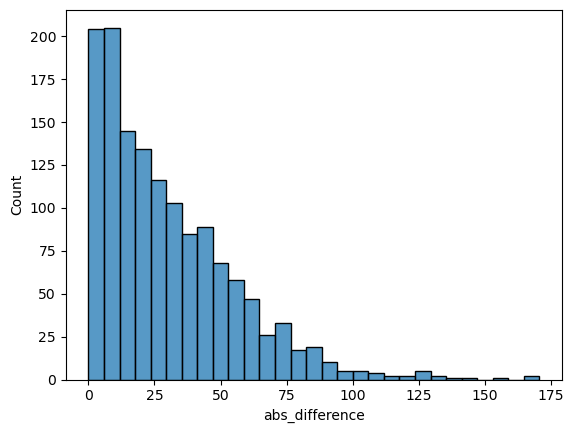

In [68]:
sns.histplot(results.abs_difference);

### Create DataFrame of the best results where the pick was projected within 16 picks

In [69]:
best = results[results.abs_difference <= 16]

In [70]:
best

,index,player_col,index,Round_col,index,year_col,index,weight_x_col,height_x_col,pos_rk_col,...,well,work,yard,year,year starter,zone,0,1,difference,abs_difference
0,1073,DeAndre Wright,1073,6,1073,2009.0,1073,198.0,70.750,41.0,...,1,0,0,0,0,0,202.292273,199,2.292273,2.292273
3,184,DeAndra Cobb,184,6,184,2005.0,184,196.0,69.750,24.0,...,0,0,3,1,0,0,185.110091,200,-15.889909,15.889909
5,2768,Charles Harris,2768,1,2768,2017.0,2768,253.0,74.750,1.0,...,0,0,0,2,0,0,28.220133,21,6.220133,6.220133
9,2862,Mack Hollins,2862,4,2862,2017.0,2862,221.0,76.000,10.0,...,0,0,0,0,0,0,104.888532,117,-13.111468,13.111468
11,3290,Irv Smith Jr.,3290,2,3290,2019.0,3290,242.0,74.375,3.0,...,0,0,0,0,0,0,42.559802,49,-7.440198,7.440198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,3053,D.J. Chark,3053,2,3053,2018.0,3053,199.0,74.875,6.0,...,0,0,3,0,0,0,59.684385,60,-1.315615,1.315615
1379,2042,Brandin Cooks,2042,1,2042,2014.0,2042,189.0,69.750,4.0,...,2,0,0,0,0,0,21.657297,19,1.657297,1.657297
1380,1632,Casey Hayward,1632,2,1632,2012.0,1632,192.0,71.375,8.0,...,0,0,0,0,0,0,65.277410,61,3.277410,3.277410
1384,2282,Phillip Dorsett,2282,1,2282,2015.0,2282,185.0,69.750,6.0,...,0,0,0,0,0,0,31.546741,28,2.546741,2.546741


### Create DataFrame of the worst results where the pick was projected more than 64 picks away

In [71]:
worst = results[results.abs_difference >= 64]

### Normalized counts of players that were the best and worst by round

In [72]:
best.Round_col.value_counts(normalize=True)

1     0.27027
2    0.183398
6    0.164093
3    0.137066
5    0.133205
4    0.088803
7    0.023166
Name: Round_col, dtype: Float64

In [73]:
worst.Round_col.value_counts(normalize=True)

3    0.323529
7    0.316176
6    0.110294
4    0.088235
2    0.073529
5    0.066176
1    0.022059
Name: Round_col, dtype: Float64

The Model was best at predicting players in round 1 and was worst at projecting players in round 3 and 7

### Position Breakdown of the model's best and worst projections

In [74]:
# Count of the normalized best position minus the actual position breakdown
best_pos = best.pos_col.value_counts(normalize=True) - results.pos_col.value_counts(normalize=True)

# Count of the normalized worst position minus the actual position breakdown
worst_pos = worst.pos_col.value_counts(normalize=True) - results.pos_col.value_counts(normalize=True)

In [75]:
best_pos.sort_values(ascending=False)

DE    0.018345
WR    0.014414
TE    0.009450
DT   -0.000240
K    -0.000688
P    -0.000688
OL   -0.001169
CB   -0.001445
RB   -0.002171
DL   -0.003338
QB   -0.003803
DB   -0.007115
LB   -0.008720
S    -0.009231
FB         NaN
LS         NaN
Name: pos_col, dtype: float64

In [76]:
worst_pos.sort_values(ascending=False)

DT    0.037887
DB    0.030275
OL    0.025177
S     0.011720
K     0.008226
CB    0.007554
QB    0.004828
P     0.000873
DL    0.000154
TE   -0.013631
WR   -0.015849
LB   -0.021609
RB   -0.028290
DE   -0.043715
FB         NaN
LS         NaN
Name: pos_col, dtype: float64

The model was best at predicting WR and DEs while it struggled with OL, S, CB, and DB. 3 of the 4 worst positions were all the secondary positions.

In [77]:
# Breakdown of the positions that were the best in the first round
best.pos_col[best.Round_col == 1].value_counts(normalize=True) - results.pos_col[results.Round_col == 1].value_counts(normalize=True)

CB    0.005424
DB   -0.003476
DE   -0.003323
DL   -0.003552
DT    0.001948
LB    0.016234
OL   -0.012070
QB   -0.019442
RB    0.012605
S    -0.014248
TE    0.000038
WR    0.019862
Name: pos_col, dtype: float64

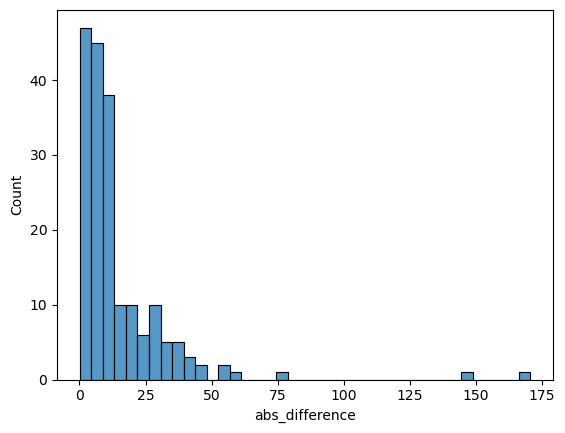

In [78]:
sns.histplot(results[results.Round_col == 1].abs_difference);

### Checking how the word develop appears in round 1 and when the difference is greater than 32

In [79]:
one_round = results[results.Round_col == 1]

In [80]:
one_round.develop

5       0
21      0
25      1
31      1
34      0
       ..
1349    0
1371    0
1373    0
1379    0
1384    0
Name: develop, Length: 187, dtype: int64

In [81]:
miss_one = one_round[one_round.abs_difference > 32]

In [82]:
miss_one.develop.mean()

0.3157894736842105

In [83]:
one_round.develop.mean()

0.25668449197860965

### Average Differences by Round

In [84]:
results[results.Round_col == 1].abs_difference.mean()

14.382542192321909

In [85]:
results[results.Round_col == 2].abs_difference.mean()

22.85311659489969

In [86]:
results[results.Round_col == 3].abs_difference.mean()

36.7965122462844

In [87]:
results[results.Round_col == 4].abs_difference.mean()

34.487394624817156

In [88]:
results[results.Round_col == 5].abs_difference.mean()

26.61980418743695

In [89]:
results[results.Round_col == 6].abs_difference.mean()

26.308642218190865

In [90]:
results[results.Round_col == 7].abs_difference.mean()

50.227854122542006

### Breakdown of features by Pos

In [91]:
cleaned_df[cleaned_df.Round_col == 1].groupby('pos_col').mean().sort_values(by='ovr_rk_col')

,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,target_col,...,tackles_assists_career_col,tackles_total_career_col,tackles_loss_career_col,sacks_career_col,pass_defended_career_col,fumbles_forced_season_col,fumbles_forced_career_col,speed_col,shuttle_agility_col,cone_agility_col
pos_col,,,,,,,,,,,,,,,,,,,,,
TE,2012.875000,251.062500,76.695312,1.312500,17.062500,91.625000,22.125000,1.0,20.3125,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.666030,144.407558,145.712496
DT,2013.204082,308.595745,75.111702,2.714286,17.489796,91.795918,22.083333,1.0,17.081633,3.0,...,54.066667,114.133333,22.888889,9.444444,4.388889,1.736842,2.379310,97.849975,136.961771,143.358176
DE,2012.900000,270.151515,76.119318,2.914286,17.871429,91.814286,22.014493,1.0,15.742857,3.0,...,49.812500,118.468750,32.085938,18.460938,5.000000,2.500000,3.877193,109.577507,148.839163,146.681849
QB,2013.962264,226.826923,75.509615,2.471698,18.264151,91.452830,22.134615,1.0,9.90566,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.558852,137.959072,133.613383
RB,2011.444444,217.138889,70.961806,2.111111,18.833333,92.083333,21.735294,1.0,17.138889,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.335770,132.875457,127.253084
WR,2014.043478,205.095238,73.043651,3.362319,20.057971,90.869565,21.692308,1.0,17.347826,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.740370,129.574828,123.432178
LB,2013.868852,244.793103,74.413793,2.344262,21.344262,90.590164,21.983333,1.0,16.836066,3.0,...,83.962963,196.481481,27.861111,12.000000,6.063830,2.451613,4.125000,110.896430,156.247868,141.032109
DB,2010.619048,199.245902,70.651639,2.741935,22.225806,91.387097,22.129032,1.0,18.936508,3.0,...,49.471698,159.037736,8.650943,2.208333,15.086957,1.444444,2.047619,103.610605,140.182586,126.084150
OL,2014.135922,313.936170,77.140957,2.553398,23.339806,90.126214,22.274510,1.0,16.834951,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.208684,133.981217,138.969886
